In [24]:
!pip3 install ipywidgets

In [25]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive

from sklearn.model_selection import train_test_split
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [26]:
data = pd.read_csv('zmienne/usdpln_d.csv')

In [27]:
#podzial na zbior treningow, testowy, walidacyjny

In [28]:
ratio = 0.8
N = int(len(data)*ratio)
train_df, test_df = data[:N], data[N:]

In [29]:
ratio = 0.2
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]

In [30]:
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
count,2279.000000,2279.000000,2279.000000,2279.000000
mean,3.396951,3.416911,3.379033,3.397633
std,0.382677,0.383065,0.380687,0.382230
min,2.646300,2.657000,2.631900,2.638900
25%,3.091500,3.108050,3.077800,3.090600
50%,3.339800,3.362400,3.317790,3.340300
75%,3.727200,3.748780,3.709345,3.727775
max,4.256520,4.279200,4.239300,4.254350


In [31]:
rolling = data.rolling(window=7)

In [32]:
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [33]:
@widgets.interact_manual(lw=(1, 100))
def plot(lw=4):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
  # data_roll.index = pd.to_datetime(data['Data'])
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean']=data_roll['Zamkniecie'].rolling(lw, min_periods=2).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10))
  ax.lines[0].set_alpha(0.3)

interactive(children=(IntSlider(value=4, description='lw', min=1), Button(description='Run Interact', style=Bu…

In [34]:
#Przygotowanie danych do uczenia na sieci LSTM(zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [35]:
#import bibliorek do stworzenia sieci LSTM

In [37]:
import tensorflow as tf #importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive

from sklearn.model_selection import train_test_split
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [38]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'keras'

In [18]:
zmienna_przewidywana = "Zamkniecie"


def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych
  dataset = scaler.fit_transform(dataset)
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler



In [19]:
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

NameError: name 'MinMaxScaler' is not defined

In [20]:
#Uczenie modelu

In [21]:
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10):
  model = Sequential()
  model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test), 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



In [22]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)
  # invert predictions
  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

  print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
  print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

  return Y_train, train_predict

In [23]:
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

NameError: name 'X_train' is not defined

In [28]:
# serialize model to JSON
model_json = history.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
history.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [29]:
evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 0.15463804258995223
Train Root Mean Squared Error: 0.16772321524997708


(array([[2.96260007, 2.89129991, 2.92050011, ..., 4.07340021, 4.10074995,
         4.10204984]]),
 array([[3.1027005],
        [3.0977294],
        [3.0781624],
        ...,
        [4.150116 ],
        [4.13139  ],
        [4.123631 ]], dtype=float32))

In [30]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 0.15463804258995223
Train Root Mean Squared Error: 0.16772321524997708


In [33]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0])
  aa=[x for x in range(N)]
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual")
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show();



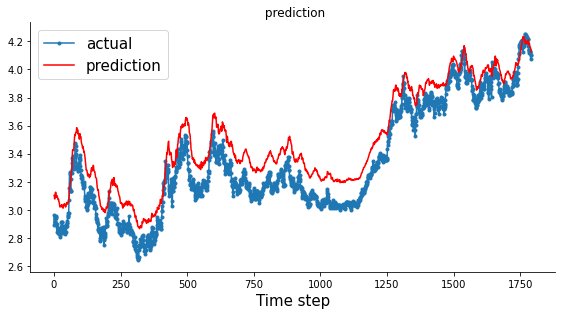

In [34]:
visualization(Y_train, train_predict)

In [32]:
#Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [35]:
#Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [36]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac


train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)


def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:
# wielkosc batchu [10, 20, 50]

for batch in [10, 20, 50]:
  history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
  evaluation_model(history,X_train, X_test, Y_train)
  print(evaluation_model)


Epoch 1/5
180/180 [==============================] - 4s 6ms/step - loss: 0.0288 - val_loss: 0.0089
Epoch 2/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0122
Epoch 3/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 4/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 5/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0036
Train Mean Absolute Error: 0.09793537070174775
Train Root Mean Squared Error: 0.11151065002474835
<function evaluation_model at 0x00000186DF6183A0>
Epoch 1/5
180/180 [==============================] - 4s 5ms/step - loss: 0.0347 - val_loss: 0.0103
Epoch 2/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 3/5
180/180 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 4/5
180/180 [==============================] - 0s 2ms/

In [38]:
#wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy